# Initial Exploration

## Problem description

Let f(x, P) be a neural network with fixed structure that takes as input a feature vector x and computes a real-valued output based on learnable parameters P.  Suppose that in response to a training example, the parameters are updated to P'.  The difference between the value of the function before and after the update is:

f(x, P) - f(x, P')

We would like a network that generalizes in the neighborhood of x.  That is, if x' is an input vector “close” to x, we would like the change in f due to the change in P at x to be similar in sign and magnitude to the change in f at x' due to the change in P.  The latter quantity can be written:

f(x', P) - f(x', P')

They are similar if the following loss is _all:

L\_gen = ((f(x, P) - f(x, P')) - (f(x', P) - f(x', P'))^2

If I update the parameters from P to P', the change in f should be similar in the neighborhood of x.  As |x - x'| gets larger, the neighborhood of the generalization increases.

Our goal is to pre-train a network using unlabeled data to get into a part of the parameter space such that generalization during pre-training is broad, thereby leading to faster convergence.  Consider the following algorithmic approach to this idea.


```
Input: X = {x1, x2, , xn}, neural network f, x, P
x is the standard deviation of the noise applied to x
p is the standard deviation of the noise applied to P

While not converged
  Choose x from X at random
  x’ = x + N(0, x)
  P’ = P + N(0, P)
  Compute derivative of  Lgen wrt P
  Update P using gradient descent

Return P
```gradient descent

Return P


In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [2]:
class TinyModel(nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(1, 10),
            nn.ReLU(),
            nn.Linear(10, 30),
            nn.ReLU(),
            nn.Linear(30, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [3]:
class SineDataset(Dataset):
    # Implement noise later
    def __init__(self, num_samples, start=0, stop=2*math.pi, include_noise=False):
        self.num_samples = num_samples
        self.start = start
        self.stop = start

        pts = np.linspace(start, stop, num_samples)
        self.data = torch.from_numpy(pts).to(torch.float32)
        self.labels = torch.sin(self.data).to(torch.float32)
        
    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    def get_data(self):
        return self.data

    def get_labels(self):
        return self.labels
        

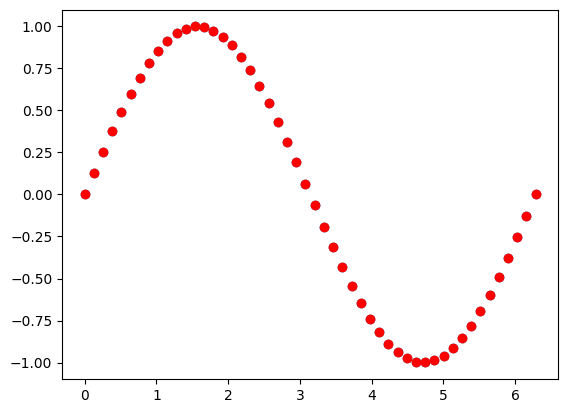

In [13]:
train_data = SineDataset(50)
test_data = SineDataset(50)
plt.scatter(train_data.get_data().numpy(), train_data.get_labels().numpy())
plt.scatter(test_data.get_data().numpy(), test_data.get_labels().numpy(), color='red')

train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [14]:
learning_rate = 1e-2
epochs = 100

sin_model = TinyModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(sin_model.parameters(), lr=learning_rate)

In [6]:
# Taken from https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html and somewhat altered
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #if batch % 100 == 0:
            #loss, current = loss.item(), (batch + 1) * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    xs = []
    ys = []
    preds = []
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            xs.append(X.item())
            preds.append(pred.item())
            ys.append(y.item())
            test_loss += loss_fn(pred, y).item()
    #fig, ax = plt.subplots()
    plt.scatter(xs, ys, label="True points")
    plt.scatter(xs, preds, label="Predictions")
    plt.legend()

    plt.show()
    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n")

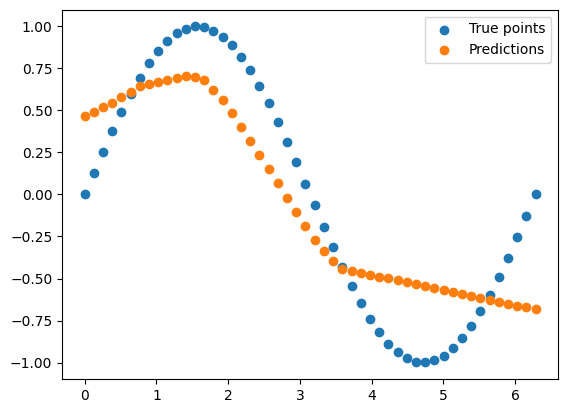

Avg loss: 0.104848 



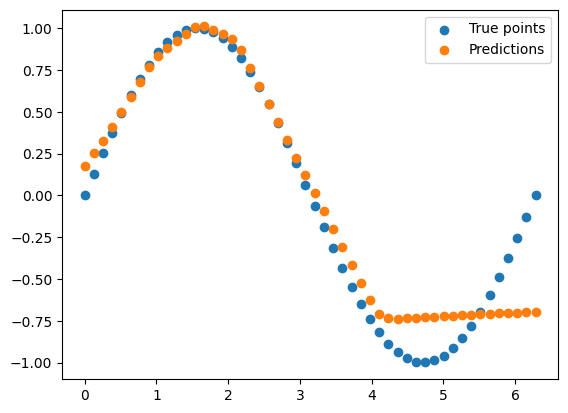

Avg loss: 0.035883 



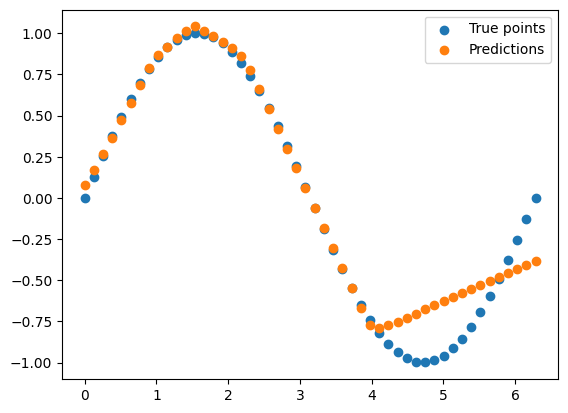

Avg loss: 0.021241 



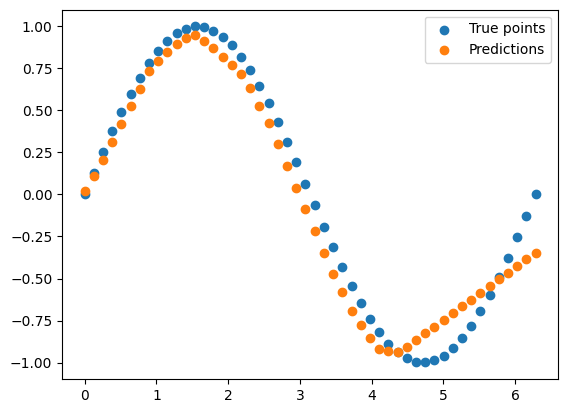

Avg loss: 0.017268 



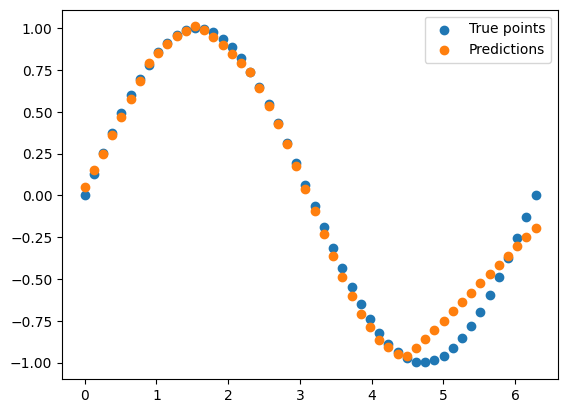

Avg loss: 0.007462 

Done!


In [15]:
for t in range(epochs):
    #print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, sin_model, loss_function, optimizer)
    if (t + 1) % int(0.2 * epochs) == 0:
        test_loop(test_dataloader, sin_model, loss_function)
print("Done!")